In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import average_precision_score

In [38]:
data = pd.read_csv('credit_data_simulate.csv')

In [39]:
class CreditData:
    def __init__(self, data):
        self.data = data

    def split_data(self, test_size=0.2):
        return train_test_split(self.data, test_size=test_size)
    
    

    def k_fold(self, k=10):
        self.data = shuffle(self.data)
        
        X = self.data.iloc[:, :-1].values
        y = self.data.iloc[:, -1].values
        kf = KFold(n_splits=k, shuffle=False)
        folds = []
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            folds.append(((X_train, y_train), (X_test, y_test)))
        return folds
        
    def normalize(self, scaler):
        X = self.data.iloc[:, 0:-1]
        y = self.data.iloc[:, -1]
        X = scaler.fit_transform(X)
        return X, y
    
    def knn(self, X_train, y_train, X_test, y_test, k=5, metric='minkowski'):
        knn = KNeighborsClassifier(n_neighbors=k, metric=metric, p=2)
        if metric == 'seuclidean':
            V = np.var(X_train, axis=0)
            knn = KNeighborsClassifier(n_neighbors=k, metric=metric, metric_params={'V': V})
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        y_pred_proba = knn.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
        cm = confusion_matrix(y_test, y_pred)
        return cm, y_pred_proba

    def plot_confusion_matrix(self, cm):
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Confusion matrix')
        plt.colorbar()
        plt.show()
    
    def get_metrics(self, y_test, y_pred_proba, cm):
        tn, fp, fn, tp = cm.ravel()
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = 2 * (precision * recall) / (precision + recall)
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        auprc = average_precision_score(y_test, y_pred_proba)
        d_index = np.log2(1+accuracy) + np.log2(1 + ((recall + precision)/2))
        return [accuracy, precision, recall, f1, d_index, roc_auc, fpr, tpr, auprc]



StandardScaler()


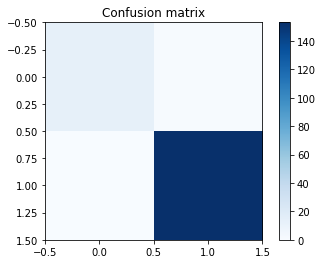

[0.9940119760479041, 0.9935064935064936, 1.0, 0.9967426710097721, 1.993330134128911, 0.9997665732959851, array([0.        , 0.        , 0.        , 0.07142857, 0.21428571,
       1.        ]), array([0.        , 0.98039216, 0.99346405, 1.        , 1.        ,
       1.        ]), 0.9999575587810882]


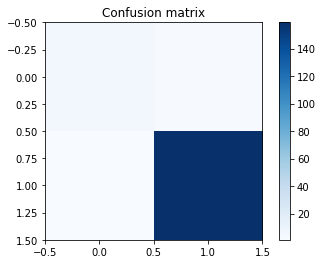

[0.9820359281437125, 0.9875776397515528, 0.99375, 0.9906542056074766, 1.9802327159293882, 0.9941964285714285, array([0.        , 0.        , 0.14285714, 0.42857143, 1.        ]), array([0.     , 0.975  , 0.99375, 0.99375, 1.     ]), 0.9996208364520958]


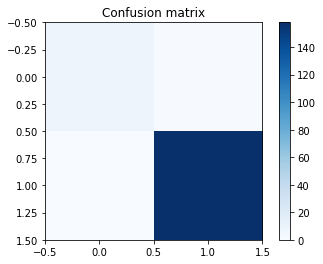

[0.9940119760479041, 0.9937106918238994, 1.0, 0.9968454258675079, 1.9934039009723827, 1.0, array([0.        , 0.        , 0.        , 0.11111111, 0.33333333,
       1.        ]), array([0.        , 0.98101266, 1.        , 1.        , 1.        ,
       1.        ]), 1.0]


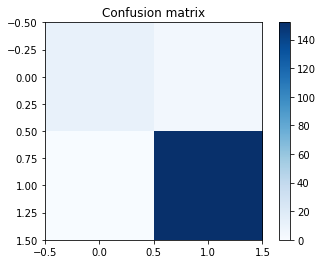

[0.9760479041916168, 0.9743589743589743, 1.0, 0.9870129870129869, 1.973340108183753, 0.8978070175438596, array([0.        , 0.2       , 0.26666667, 0.26666667, 0.4       ,
       1.        ]), array([0.        , 0.98684211, 0.98684211, 1.        , 1.        ,
       1.        ]), 0.9803127728824323]


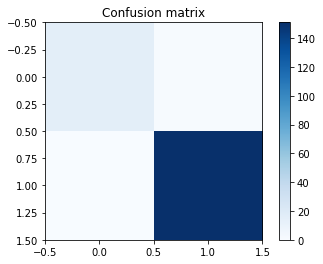

[0.9940119760479041, 0.993421052631579, 1.0, 0.9966996699669968, 1.9932992674093064, 1.0, array([0.   , 0.   , 0.   , 0.125, 1.   ]), array([0.        , 0.99337748, 1.        , 1.        , 1.        ]), 1.0]


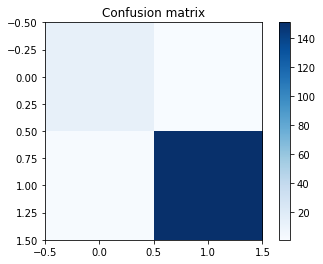

[0.9820359281437125, 0.993421052631579, 0.9869281045751634, 0.9901639344262295, 1.97987810421678, 0.9946311858076564, array([0.        , 0.        , 0.07142857, 0.07142857, 1.        ]), array([0.        , 0.95424837, 0.98039216, 0.99346405, 1.        ]), 0.999193220283429]


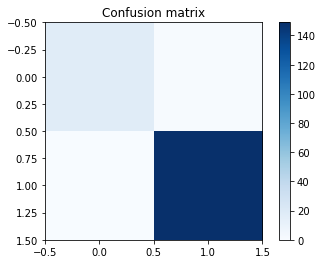

[0.9940119760479041, 0.9933333333333333, 1.0, 0.9966555183946488, 1.9932675768901147, 0.999813571961223, array([0.        , 0.        , 0.05555556, 0.22222222, 1.        ]), array([0.        , 0.99328859, 1.        , 1.        , 1.        ]), 0.9999552572706936]


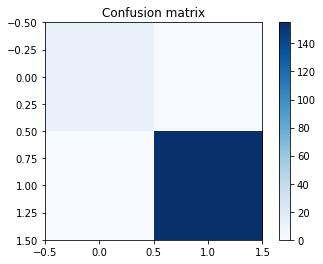

[0.9940119760479041, 0.9935897435897436, 1.0, 0.9967845659163987, 1.9933602087589635, 0.9577956989247312, array([0.        , 0.08333333, 0.08333333, 0.25      , 1.        ]), array([0.        , 0.98709677, 1.        , 1.        , 1.        ]), 0.9935075677011161]


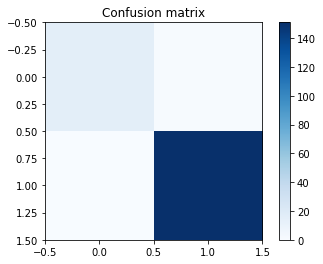

[0.9940119760479041, 0.993421052631579, 1.0, 0.9966996699669968, 1.9932992674093064, 0.9997930463576159, array([0.    , 0.    , 0.    , 0.0625, 0.125 , 0.25  , 1.    ]), array([0.        , 0.97350993, 0.99337748, 1.        , 1.        ,
       1.        , 1.        ]), 0.9999564308121297]


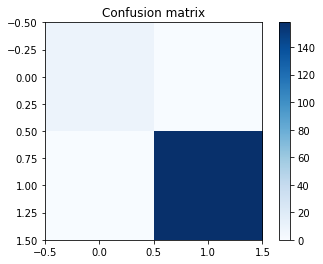

[1.0, 1.0, 1.0, 1.0, 2.0, 1.0, array([0.        , 0.        , 0.        , 0.        , 0.11111111,
       1.        ]), array([0.        , 0.97468354, 0.99367089, 1.        , 1.        ,
       1.        ]), 1.0]


ValueError: not enough values to unpack (expected 4, got 2)

In [41]:
credit_data = CreditData(data)
folds = credit_data.k_fold(k=10)
scalers = [StandardScaler(), MinMaxScaler(), RobustScaler(), MaxAbsScaler()]
for scaler in scalers:
    print(scaler)
    for fold in folds:
        (X_train, y_train), (X_test, y_test) = fold
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        cm, y_pred_proba = credit_data.knn(X_train_scaled, y_train, X_test_scaled, y_test, k=5, metric='correlation')
        credit_data.plot_confusion_matrix(cm)
        metrics = credit_data.get_metrics(y_test, y_pred_proba, cm)
        print(metrics)
    
    # also do train test split
    X_train, X_test, y_train, y_test = credit_data.split_data()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    cm, y_pred_proba = credit_data.knn(X_train_scaled, y_train, X_test_scaled, y_test, k=5, metric='correlation')
    credit_data.plot_confusion_matrix(cm)
    metrics = credit_data.get_metrics(y_test, y_pred_proba, cm)
    print(metrics)
    

